## 1.基本介绍

### 1.1 实验目标
预测泰坦尼克号上的生还者

### 1.2 实验描述
泰坦尼克号的沉没是历史上最臭名昭著的沉船事件之一。1912年4月15日，在它的处女首航中，泰坦尼克号在撞击冰山后沉没，2224名乘客和船员中1502名丧失生命。这个震撼的灾难震惊了国际社会，并且引发了针对航运的更好地安全规范。

造成这次事故的原因之一是缺乏足够的救生艇。尽管在灾难中生还存在一些幸运的因素，但确实存在一些人群存在更大的可能生还，比如妇女，儿童以及上层人士。

在本次试验中，我们需要全面地分析哪一类人群更容易生还。特别地，我们需要应用机器学习的工具去预测哪些乘客在事故中幸免遇难。

## 2.数据理解

### 2.1 导入库
为了对数据进行更好地理解，我们需要导入一些python的库。在本次实验中，我们需要的第三方库主要包括:
1. **numpy**: python中可以对数组进行高效处理的第三方库
2. **pandas**: python中对类表格数据的处理工具
3. **sklearn**: python中常见机器学习模型的第三方库
4. **matplotlib**: python强大的绘图库
5. **seaborn**: python中用于统计分析绘图的第三方库，相较于matplotlib，该库更加侧重于统计方面的绘图

In [5]:
# 有时候使用pandas包，对df表作处理时，常常会伴随警告出现，可以作如下处理
import warnings
warnings.filterwarnings('ignore')

In [2]:
import numpy as np
import pandas as pd

In [ ]:
# 在本次实验中我们使用决策树和朴素贝叶斯模型
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB

In [6]:
# 同时我们需要一些数据预处理和特征选择方面的工具
from sklearn.preprocessing import Imputer, Normalizer, scale
from sklearn.cross_validation import train_test_split, StratifiedKFold
from sklearn.feature_selection import RFECV

In [7]:
# 可视化的一些工具
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab
import seaborn as sns

In [9]:
# 配置绘图时的基本参数
%matplotlib inline
mpl.style.use('ggplot')   # 这是个全局变量，定义绘图时的风格,ggplot是R语言中的一种常用的绘图风格
sns.set_style('white')    # 设置绘图的美学样式
pylab.rcParams['figure.figsize']=(8,6)   # 设置图表的大小

### 2.1  设置一些辅助函数（主要是用于绘图）
以下函数同样可以应用在其他实验中。

In [10]:
#  绘制统计直方图
def plot_histograms( df , variables , n_rows , n_cols ):
    fig = plt.figure( figsize = ( 16 , 12 ) )
    for i, var_name in enumerate( variables ):
        ax=fig.add_subplot( n_rows , n_cols , i+1 )
        df[ var_name ].hist( bins=10 , ax=ax )
        ax.set_title( 'Skew: ' + str( round( float( df[ var_name ].skew() ) , ) ) ) # + ' ' + var_name ) #var_name+" Distribution")
        ax.set_xticklabels( [] , visible=False )
        ax.set_yticklabels( [] , visible=False )
    fig.tight_layout()  # Improves appearance a bit.
    plt.show()

In [11]:
# 绘制数据分布图
def plot_distribution( df , var , target , **kwargs ):
    row = kwargs.get( 'row' , None )
    col = kwargs.get( 'col' , None )
    facet = sns.FacetGrid( df , hue=target , aspect=4 , row = row , col = col )
    facet.map( sns.kdeplot , var , shade= True )
    facet.set( xlim=( 0 , df[ var ].max() ) )
    facet.add_legend()

In [12]:
# 绘制类别变量的分布图
def plot_categories( df , cat , target , **kwargs ):
    row = kwargs.get( 'row' , None )
    col = kwargs.get( 'col' , None )
    facet = sns.FacetGrid( df , row = row , col = col )
    facet.map( sns.barplot , cat , target )
    facet.add_legend()

In [13]:
# 绘制变量与变量之间相关系数的网格图
def plot_correlation_map( df ):
    corr = titanic.corr()
    _ , ax = plt.subplots( figsize =( 12 , 10 ) )
    cmap = sns.diverging_palette( 220 , 10 , as_cmap = True )
    _ = sns.heatmap(
        corr, 
        cmap = cmap,
        square=True, 
        cbar_kws={ 'shrink' : .9 }, 
        ax=ax, 
        annot = True, 
        annot_kws = { 'fontsize' : 12 }
    )

In [20]:
def describe_more( df ):
    var = [] ; l = [] ; t = []
    for x in df:
        var.append( x )
        l.append( len( pd.value_counts( df[ x ] ) ) )
        t.append( df[ x ].dtypes )
    levels = pd.DataFrame( { 'Variable' : var , 'Levels' : l , 'Datatype' : t } )
    levels.sort_values( by = 'Levels' , inplace = True )
    return levels

In [39]:
def plot_variable_importance( X , y ):
    tree = DecisionTreeClassifier( random_state = 99 )
    tree.fit( X , y )
    plot_model_var_imp( tree , X , y )

In [40]:
def plot_model_var_imp( model , X , y ):
    imp = pd.DataFrame( 
        model.feature_importances_  , 
        columns = [ 'Importance' ] , 
        index = X.columns 
    )
    imp = imp.sort_values( [ 'Importance' ] , ascending = True )
    imp[ : 10 ].plot( kind = 'barh' )
    print (model.score( X , y ))

### 2.3 加载数据
利用pandas工具将表格中的数据读入，我们需要读入训练集和测试集

In [14]:
train = pd.read_csv("all/train.csv")
test = pd.read_csv("all/test.csv")
full = train.append(test, ignore_index = True)
titanic = full[:891]
del train, test
print('Datasets:','full:',full.shape,'titanic:',titanic.shape)

Datasets: full: (1309, 12) titanic: (891, 12)


### 2.4  对数据进行统计分析和可视化
为了更好地理解数据，我们需要分析在所有的变量中哪些是重要的影响因素，以及不同变量与目标变量之间的关系。我们首先查看数据集的前5行数据。每个变量的意义和取值如下表所示：

| 变量 | 描述 | 取值 |
| :----- | :------ | :------ |
| Age | 乘客的年龄 | 年龄如果小于1，将以小数呈现，年龄如果是估计的，会以xx.5形式呈现。|
| Cabin | 船舱编号 |
| Embarked | 登船港口 | C=瑟堡（法国西北部港市）,Q=昆士城, S=南安普敦 |
| Fare | 票价 |
| Name | 姓名 |
| Parch | 在船上的自己父母/孩子的数量 |
| Pclass | 社会经济地位 | 1=上等, 2=中等, 3=下等 |
| Sex | 性别 |
| SibSp | 在船上的自己兄弟姐妹/配偶的数量 |
| Survived | 是否生还 | 0=No, 1=Yes |
| Ticket | 船票编号 |

In [15]:
titanic.head()

,Age,Cabin,Embarked,Fare,Name,Parch,PassengerId,Pclass,Sex,SibSp,Survived,Ticket
0,22.0,NaN,S,7.2500,"Braund, Mr. Owen Harris",0,1,3,male,1,0.0,A/5 21171
1,38.0,C85,C,71.2833,"Cumings, Mrs. John Bradley (Florence Briggs Th...",0,2,1,female,1,1.0,PC 17599
2,26.0,NaN,S,7.9250,"Heikkinen, Miss. Laina",0,3,3,female,0,1.0,STON/O2. 3101282
3,35.0,C123,S,53.1000,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",0,4,1,female,1,1.0,113803
4,35.0,NaN,S,8.0500,"Allen, Mr. William Henry",0,5,3,male,0,0.0,373450


#### 2.4.1 查看关于变量的主要统计信息
pandas 可以较快地查看所有变量的基本的统计信息。

In [16]:
titanic.describe()

,Age,Fare,Parch,PassengerId,Pclass,SibSp,Survived
count,714.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000
mean,29.699118,32.204208,0.381594,446.000000,2.308642,0.523008,0.383838
std,14.526497,49.693429,0.806057,257.353842,0.836071,1.102743,0.486592
min,0.420000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000
25%,20.125000,7.910400,0.000000,223.500000,2.000000,0.000000,0.000000
50%,28.000000,14.454200,0.000000,446.000000,3.000000,0.000000,0.000000
75%,38.000000,31.000000,0.000000,668.500000,3.000000,1.000000,1.000000
max,80.000000,512.329200,6.000000,891.000000,3.000000,8.000000,1.000000


#### 2.4.2 变量之间的热关联图可以让我们了解变量之间的相关程度
其中对角线为每个变量的方差，非对角线元素为两个变量之间的相关系数，变化范围为[-1,1]，其中1表示完全正线性相关，-1代表完全负线性相关。

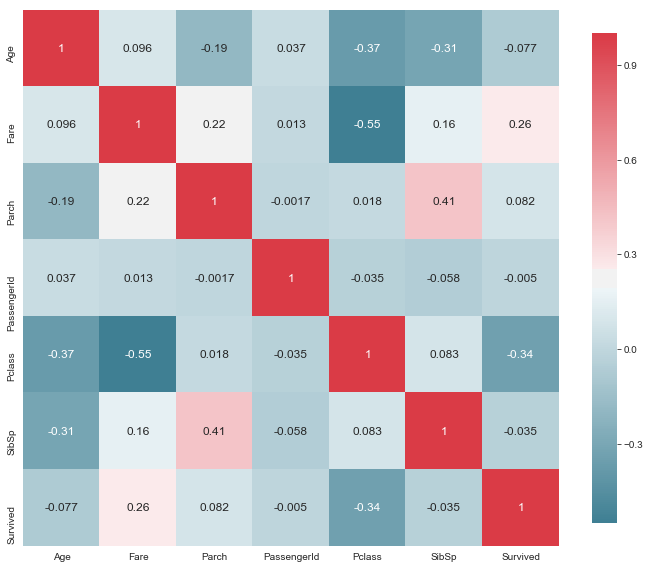

In [17]:
plot_correlation_map(titanic)

#### 2.4.3  连续变量与目标变量之间的关系

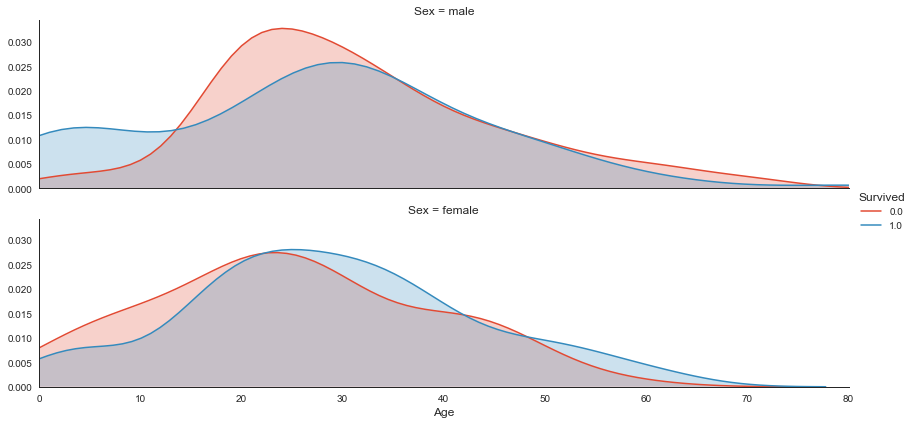

In [18]:
# 考虑年龄与是否生还之间的关系，其中男女分别进行考虑
plot_distribution(titanic,var='Age',target='Survived',row='Sex')

通过观察上面的图形，我们发现，对于男性来说，在生还者中大部分年龄分布在30岁左右，而遇难者的年龄主要在25岁左右。对于女性来说，生还者的年龄主要分布在25岁左右，遇难者的年龄主要分布在23岁左右。同时我们发现不论对于男性还是女性，生还与遇难者的年龄分布都是不一样的，也就是说年龄与是否生还有直接的关系，从而实现了对特征的选择。

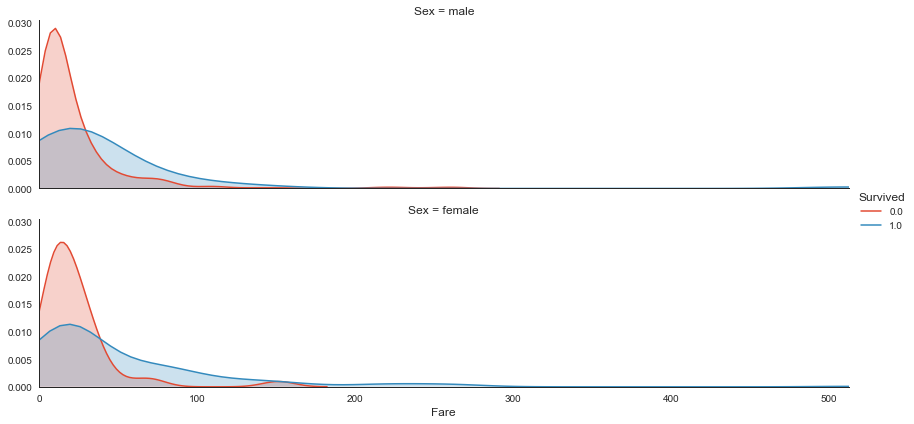

In [19]:
# 考虑票价与是否生还之间的关系
plot_distribution(titanic,var='Fare',target='Survived',row='Sex')

我们发现，生还者与遇难者的票价的分布差异特别大，说明票价与是否生还的关联很大。

#### 2.4.4 离散变量与目标变量的关系

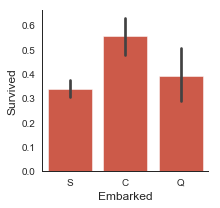

In [21]:
# 登船港口是类别变量，通过统计直方图，我们分析它与是否生还的关系
plot_categories(titanic, cat = 'Embarked', target = 'Survived')

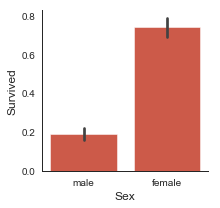

In [22]:
# 性别与是否生还的关系
plot_categories(titanic, cat = 'Sex', target = 'Survived')

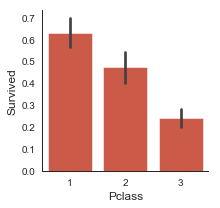

In [23]:
# 社会经济地位与是否生还的关系
plot_categories(titanic, cat = 'Pclass', target = 'Survived')

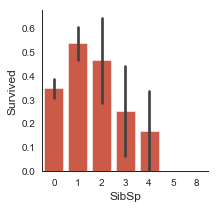

In [24]:
# 含兄妹/配偶数量与是否生还的关系
plot_categories(titanic, cat = 'SibSp', target = 'Survived')

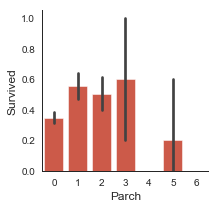

In [25]:
# 含父母/孩子数量与是否生还的关系
plot_categories(titanic, cat = 'Parch', target = 'Survived')

## 3 数据准备

### 3.1 将类别变量转换为数值变量

类似于 **Embarked(登船口),Pclass(社会经济地位),Sex(性别)** 这一列类别变量需要转换为数值变量。因为模型算法只能处理数值类型的变量。转换的方式一般采用one-hot的方式。

In [26]:
# 将性别的二值特征转换为0,1
sex = pd.Series(np.where(full.Sex == 'male', 1, 0), name = 'Sex')

In [27]:
# 为登船口创建哑编码
embarked = pd.get_dummies(full.Embarked, prefix='Embarked')
embarked.head()

,Embarked_C,Embarked_Q,Embarked_S
0,0,0,1
1,1,0,0
2,0,0,1
3,0,0,1
4,0,0,1


In [29]:
# 为社会经济地位创建哑编码
pclass = pd.get_dummies(full.Pclass, prefix='Pclass')
pclass.head()

,Pclass_1,Pclass_2,Pclass_3
0,0,0,1
1,1,0,0
2,0,0,1
3,1,0,0
4,0,0,1


### 3.2 补全变量中的缺失值
大部分机器学习算法都需要所有变量都具备值。一种补全缺失值的方式是采用训练集中的样本的平均值对缺失值进行补充。

In [30]:
# 创建一个新的数据集
imputed = pd.DataFrame()
# 采用平均值对年龄进行补全
imputed['Age'] = full.Age.fillna(full.Age.mean())
# 采用票价均值对票价进行补全
imputed['Fare'] = full.Fare.fillna(full.Fare.mean())
imputed.head()

,Age,Fare
0,22.0,7.2500
1,38.0,71.2833
2,26.0,7.9250
3,35.0,53.1000
4,35.0,8.0500


### 3.3 特征工程-创建新变量

#### 3.3.1 从乘客姓名中提取头衔
头衔可以反映乘客的社会地位，或许对预测有影响。

In [32]:
title = pd.DataFrame()
title['Title'] = full['Name'].map(lambda name: name.split(',')[1].split('.')[0].strip())
# 头衔的映射关系
Title_Dictionary = {
                    "Capt":       "Officer",
                    "Col":        "Officer",
                    "Major":      "Officer",
                    "Jonkheer":   "Royalty",
                    "Don":        "Royalty",
                    "Sir" :       "Royalty",
                    "Dr":         "Officer",
                    "Rev":        "Officer",
                    "the Countess":"Royalty",
                    "Dona":       "Royalty",
                    "Mme":        "Mrs",
                    "Mlle":       "Miss",
                    "Ms":         "Mrs",
                    "Mr" :        "Mr",
                    "Mrs" :       "Mrs",
                    "Miss" :      "Miss",
                    "Master" :    "Master",
                    "Lady" :      "Royalty"
                    }
title['Title'] = title.Title.map(Title_Dictionary)
title = pd.get_dummies(title.Title)
title.head()

,Master,Miss,Mr,Mrs,Officer,Royalty
0,0,0,1,0,0,0
1,0,0,0,1,0,0
2,0,1,0,0,0,0
3,0,0,0,1,0,0
4,0,0,1,0,0,0


#### 3.3.2 从船舱编号中提取船舱的类别信息

In [33]:
cabin = pd.DataFrame()
# 将表格中的缺失值补充为 'U'
cabin['Cabin'] = full.Cabin.fillna('U')
# 提取船舱编号的首字母
cabin['Cabin'] = cabin['Cabin'].map(lambda c:c[0])
# 进行哑编码
cabin = pd.get_dummies(cabin['Cabin'], prefix='Cabin')
cabin.head()

,Cabin_A,Cabin_B,Cabin_C,Cabin_D,Cabin_E,Cabin_F,Cabin_G,Cabin_T,Cabin_U
0,0,0,0,0,0,0,0,0,1
1,0,0,1,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,1
3,0,0,1,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,1


#### 3.3.3 从船票编号上提取船票种类

In [34]:
# 定义一个提取船票编号前缀的函数，如果没有前缀（比如编号只是数字）则返回'XXX'
def cleanTicket( ticket ):
    ticket = ticket.replace( '.' , '' )
    ticket = ticket.replace( '/' , '' )
    ticket = ticket.split()
    ticket = map( lambda t : t.strip() , ticket )
    ticket = list(filter( lambda t : not t.isdigit() , ticket ))
    if len( ticket ) > 0:
        return ticket[0]
    else: 
        return 'XXX'
ticket = pd.DataFrame()
ticket['Ticket'] = full['Ticket'].map(cleanTicket)
ticket = pd.get_dummies(ticket['Ticket'], prefix='Ticket')
ticket.shape
ticket.head()

,Ticket_A,Ticket_A4,Ticket_A5,Ticket_AQ3,Ticket_AQ4,Ticket_AS,Ticket_C,Ticket_CA,Ticket_CASOTON,Ticket_FC,...,Ticket_SOTONO2,Ticket_SOTONOQ,Ticket_SP,Ticket_STONO,Ticket_STONO2,Ticket_STONOQ,Ticket_SWPP,Ticket_WC,Ticket_WEP,Ticket_XXX
0,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1


#### 3.3.4 创建家庭规模以及规模类别
使用Parch 和SibSp 创建家庭规模的大小尺寸

In [35]:
family = pd.DataFrame()
family['FamilySize'] = full['Parch'] + full['SibSp'] + 1
family[ 'Family_Single' ] = family[ 'FamilySize' ].map( lambda s : 1 if s == 1 else 0 )
family[ 'Family_Small' ]  = family[ 'FamilySize' ].map( lambda s : 1 if 2 <= s <= 4 else 0 )
family[ 'Family_Large' ]  = family[ 'FamilySize' ].map( lambda s : 1 if 5 <= s else 0 )
family.head()

,FamilySize,Family_Single,Family_Small,Family_Large
0,2,0,1,0
1,2,0,1,0
2,1,1,0,0
3,2,0,1,0
4,1,1,0,0


### 3.4 数据集汇总

#### 3.4.1 变量选择
将前面的变量进行融合，形成新的数据集

In [36]:
full_X = pd.concat([imputed, embarked, cabin, sex], axis=1)
full_X.head()

,Age,Fare,Embarked_C,Embarked_Q,Embarked_S,Cabin_A,Cabin_B,Cabin_C,Cabin_D,Cabin_E,Cabin_F,Cabin_G,Cabin_T,Cabin_U,Sex
0,22.0,7.2500,0,0,1,0,0,0,0,0,0,0,0,1,1
1,38.0,71.2833,1,0,0,0,0,1,0,0,0,0,0,0,0
2,26.0,7.9250,0,0,1,0,0,0,0,0,0,0,0,1,0
3,35.0,53.1000,0,0,1,0,0,1,0,0,0,0,0,0,0
4,35.0,8.0500,0,0,1,0,0,0,0,0,0,0,0,1,1


#### 3.4.2 创建数据集
对训练集和测试集进行分割。

In [47]:
train_valid_X = full_X[0:891]
train_valid_y = titanic.Survived
test_X = full_X[891:]
train_X , valid_X , train_y , valid_y = train_test_split( train_valid_X , train_valid_y , train_size = .7 )
print (full_X.shape , train_X.shape , valid_X.shape , train_y.shape , valid_y.shape , test_X.shape)

(1309, 15) (623, 15) (268, 15) (623,) (268,) (418, 15)


#### 3.4.3 特征重要性
选择模型使用的最优的特征。

0.9887640449438202


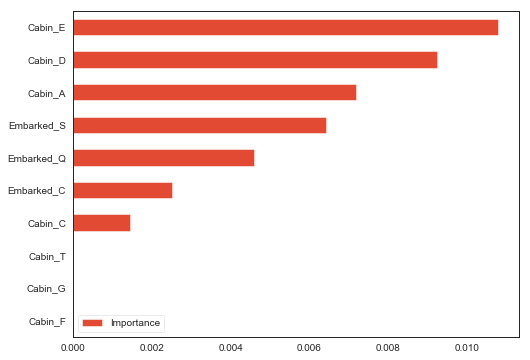

In [41]:
plot_variable_importance(train_X, train_y)

## 4.模型建立及性能评价
采用决策树和朴素贝叶斯模型对数据进行训练

### 4.1 决策树模型

In [42]:
dt = DecisionTreeClassifier()
dt.fit(train_X, train_y)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

In [51]:
accuracy = dt.score(valid_X, valid_y)
print('预测精度为',accuracy)

预测精度为 0.9402985074626866


### 4.2 朴素贝叶斯模型

In [52]:
nb = GaussianNB()
nb.fit(train_X, train_y)

GaussianNB(priors=None)

In [53]:
accuracy = nb.score(valid_X, valid_y)
print('预测精度为',accuracy)

预测精度为 0.6865671641791045


### 根据结果我们可以发现，并不是所有的模型都适用于任何形式的数据集。决策树模型作为一种可以自适应的模型，其依托的模型假设有限，所以可以更好地使用数据。而高斯朴素贝叶斯模型，因为假设了特征服从高斯分布（实际上可能有些特征并不是），导致最终的结果并不如意。